In [17]:
#借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！
# !python -m pip install pandas matplotlib scikit-learn-intelex scikit-learn openpyxl tensorboard seaborn ipykernel ipywidgets keras plotly plotly_express
# !python -m pip install  tensorflow==2.15.*
# !python -m pip install  tensorflow[and-cuda]==2.15.*
#


In [18]:
# 本导入顺序可以看到类型
import tensorflow as tf
import keras
# import tensorflow_datasets as tfds
import datetime
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
from sklearn import preprocessing as skl
from sklearn.model_selection import train_test_split

# from tensorflow import keras

from keras import layers
from keras import models



patch_sklearn()
# from attention_utils import get_activations

#更好地兼容 Python 3 的行为和特性，使得代码可以在 Python 2 和 Python 3 下运行得更加一致
# from __future__ import absolute_import,division,print_function,unicode_literals
from matplotlib import pyplot as plt
from matplotlib import ticker as mt
# 或者直接指定字体文件路径
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans Mono']  # 系统自带的黑体
plt.rcParams['font.serif'] = ['SimHei']  # 系统自带的宋体
plt.rcParams['font.family'] = [
    'SimHei',
    'DejaVu Sans Mono',  # 显示负号的字体
    # 'Liberation Mono',
    'Consolas',
    'Courier New',
    'monospace',
    'sans-serif',
    'serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
]
plt.rcParams['axes.unicode_minus'] = False  # 设置matplotlib显示正常的负号而非减号样式

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [19]:
print(' ')
print(f'{datetime.datetime.now()} tensorflow版本:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")
print(' ')
print('gpus： ')
print(gpus)
print(' ')
print('gpus')
# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


 
2024-05-14 10:53:24.895986 tensorflow版本: 2.16.1
 
gpus： 
[]
 
gpus
Available GPU devices: []


In [20]:
# # 读取数据

from load_data import load_fixed_data, categories

R_CREATE = False
R_CREATE = True


def create_dynamic_globals(dyn_name, value, global_vars, read_cache: bool = True):
    """
    :param dyn_name: 动态变量名
    :param value: 动态变量值
    :param global_vars: 全局变量字典
    :return:
    """
    # print(dyn_name, global_vars[dyn_name])
    if read_cache and (R_CREATE or dyn_name not in global_vars or global_vars[dyn_name] == None):
        # 如果确实需要在全局作用域创建真正的全局变量，可以使用exec，但这不是推荐做法
        if callable(value):

            v = value(dyn_name)
            s = f'global {dyn_name}; {dyn_name} = v'
            # print(s)
            exec(s)
        else:
            exec(f'global {dyn_name}; {dyn_name} = {value}')

    return globals()[dyn_name]


def create_global_vars(global_vars, varprefix: str = 'data_', read_cache: bool = True):

    for gvar in global_vars:
        #
        if gvar.startswith('_'):
            continue
        if gvar.startswith(varprefix):
            print(gvar, )
            create_dynamic_globals(gvar, lambda f: load_fixed_data(f'./data/{f}.xlsx', read_from_csv=True), global_vars, read_cache)


data_17 = pd.DataFrame()
data_21 = data_17
data_22 = data_17
data_23 = data_17
# data_24 = data_17 #无数据，不能使用

create_global_vars(globals(), varprefix='data_')

# data_17.dtypes

data_17
data_21
data_22
data_23


In [21]:
from libs.config import *

In [22]:
#组合数据集
from load_data import categories

numeric_col_names = [
    '原始重量',
    # '稳定重量',
    '轴重',
    'su_ad',
    '原始重量_diff',
    # '稳定重量_diff',
    '轴重_diff',
    'su_ad_diff',
    'wpu_x',
    'wpu_y',
    'wpu_z',
    'su_x',
    'su_y',
    'su_z',
    # 'su_x_diff',
    'su_y_diff',
    'su_z_diff',
    'wpu_x_diff',
    'wpu_y_diff',
    'wpu_z_diff',
    # '速度',
    # '估计重量',
]
# numeric_col_names = [
#     'wpu_x_diff',
#     'wpu_y_diff',
#     'wpu_z_diff',
# ]
# delete some
# ['Unnamed: 0' ,
# 'label'      , '时间'         , '轨迹时间'       , '速度',, '估计重量'
# '原始重量'       , '稳定重量'       , '轴重'         , 'su_ad',
# '原始重量_diff'  , '稳定重量_diff'  , '轴重_diff'    , 'su_ad_diff',
# 'wpu_x'      , 'wpu_y'      , 'wpu_z'      ,
# 'wpu_x_diff' , 'wpu_y_diff' , 'wpu_z_diff',
# 'su_x'       , 'su_y'       , 'su_z'       ,
# 'su_x_diff'  , 'su_y_diff'  , 'su_z_diff'
# ]
label_col_names = ["label"]
time_col_names = ["时间", "轨迹时间"]

all_col_names = numeric_col_names + label_col_names + time_col_names
df17, df21, df22, df23 = data_17[all_col_names], data_21[all_col_names], data_22[all_col_names], data_23[all_col_names]

class_num = len(categories)

origindata = pd.concat([df17, df21, df22, df23], axis=0, ignore_index=True)

# print(origindata.columns)
 

In [23]:
# check 数据集有缺失值
shapea= origindata.shape
df_all_data = origindata.dropna()
shapeb =df_all_data.shape
print(shapea, shapeb)
if shapea != shapeb:
    print(shapea,shapeb)
    ValueError("数据集有缺失值")

# missing_values

(97349, 20) (97349, 20)


In [24]:
from locale import Error
import tensorflow as tf
import tensorflow as tf
import numpy as np

from turtle import up
import pandas as pd
import scipy
from scipy.stats import iqr


def windowed_dataset(dataset: tf.data.Dataset, window_size=5, shift=1, stride=2):
    if window_size == None or window_size <= 0:
        return dataset

    def sub_to_batch(t1, t2=None):
        t1_batches = t1.batch(window_size, drop_remainder=True)

        if t2 is not None:
            t2_batches = t2.batch(window_size, drop_remainder=True)
            return tf.data.Dataset.zip((t1_batches, t2_batches))
        else:
            return t1_batches

    def pick_batch(t1, t2: tf.Tensor | None):
        #return (t1, t2)
        if t2 is None:
            return t1
        else:

            # 获取张量的维度信息
            ndim = 0 if t2.ndim is None else t2.ndim

            # 确保张量至少有二维
            if ndim >= 2:
                # 获取第二维的大小
                second_dim_size = t2.shape[1] if ndim > 2 else t2.shape[0]
                # 提取每个第二维元素的第一个数
                # 如果张量是二维的，直接使用 tensor[:, 0]
                # 如果张量大于二维，确保正确处理其他维度
                if ndim > 2:
                    first_elements = t2[0, ...]  # 使用...来保持其余维度不变
                else:  # 对于二维张量
                    first_elements = t2[0]

                print(first_elements.shape)
                return t1, first_elements
            else:
                msg = "The tensor does not have at least two dimensions to extract elements from the second dimension."
                print(msg)
                Error(msg)

    return dataset.window(window_size, shift=shift, stride=stride, drop_remainder=True).flat_map(sub_to_batch).map(pick_batch)
    return windows  #.batch(window_size, drop_remainder=drop_remainder)


# def windowed_batch_dataframe(df: pd.DataFrame, window_size=4, batch_size=None):
#     df = df.copy()
#     if batch_size is not None and batch_size > 0:
#         dataset = windowed_dataset(tf.data.Dataset.from_tensor_slices(df.values), window_size).batch(batch_size=batch_size, drop_remainder=True)
#     else:
#         dataset = windowed_dataset(tf.data.Dataset.from_tensor_slices(df.values), window_size)
#     return dataset


def windowed_batch_dataset(ds: tf.data.Dataset, window_size=4, batch_size=None):

    if batch_size is not None and batch_size > 0:
        dataset = windowed_dataset(ds, window_size).batch(batch_size=batch_size, drop_remainder=True)
    else:
        dataset = windowed_dataset(ds, window_size)
    return dataset


def convert_to_numpy(ds: tf.data.Dataset):
    # 将 dataset 转换为 NumPy 数组
    numpy_array = None
    for data in ds.as_numpy_iterator():
        # 确保数据是 NumPy 数组
        data_np = np.array(data)

        # 如果 numpy_array 还没有初始化，初始化它
        if numpy_array is None:
            numpy_array = data_np
        else:
            # # 确保数据的形状与 numpy_array 相同
            # if data_np.shape[1:] != numpy_array.shape[1:]:
            #     raise ValueError("All data items must have the same shape except for the first dimension.")

            # 垂直堆叠数据
            numpy_array = np.vstack((numpy_array, data_np))

    return numpy_array


def get_shape(*args):
    shapes = []
    for arg in args:
        shapes.append(arg.shape if arg is not None else None)
    return shapes

In [25]:
from turtle import up
import scipy
from scipy.stats import iqr

p = 1.5


def replace_iqr_outliers(df: pd.DataFrame, current_col_names: list[str], with_new_col=True):
    q = 0.25
    _df = df.copy()
    numeric_iqr_col_names = [str(col + '_iqr') for col in numeric_col_names]
    tuple_cols = zip(numeric_col_names, numeric_iqr_col_names)
    for column, new_col in tuple_cols:
        _df[column] = _df[column].astype(float)
        q1 = _df[column].quantile(q)  #.quantile(0.25)
        q3 = _df[column].quantile(1 - q)  #.quantile(0.75)
        iqr_value = iqr(_df[column], rng=(q * 100, (1 - q) * 100))
        # print('------', iqr_value)

        lower_bound = q1 - p * iqr_value
        upper_bound = q3 + p * iqr_value
        if with_new_col:
            _df[new_col] = _df[column]
            _df.loc[_df[column] < lower_bound, new_col] = lower_bound
            _df.loc[_df[column] > upper_bound, new_col] = upper_bound

        else:
            _df.loc[_df[column] < lower_bound, column] = lower_bound
            _df.loc[_df[column] > upper_bound, column] = upper_bound
    if with_new_col:
        return _df, list(dict.fromkeys(current_col_names + numeric_iqr_col_names))
    else:
        return _df, current_col_names


def abs_cols(df: pd.DataFrame, current_col_names: list[str]):
    _df = df.copy()

    numeric_abs_col_names = [str(col + '_abs') for col in numeric_col_names]
    for numeric_col, abs_col in zip(numeric_col_names, numeric_abs_col_names):
        df[abs_col] = abs(df[numeric_col])

    return df, list(dict.fromkeys(current_col_names + numeric_abs_col_names))


def smooth_cols(df: pd.DataFrame, current_col_names: list[str]):
    _df = df.copy()

    numeric_smooth_col_names = [str(col + '_smooth') for col in numeric_col_names]
    for numeric_col, smooth_col in zip(numeric_col_names, numeric_smooth_col_names):
        df[smooth_col] = abs(df[numeric_col])

    return df, list(dict.fromkeys(current_col_names + numeric_smooth_col_names))


from joblib import dump, load


def normalize_df(alldata_df: pd.DataFrame, feature_col_names: list[str]):
    df = alldata_df.copy()
    # if os.path.exists('scaler.joblib'):
    #     scaler = load('scaler.joblib')
    #     normalized = scaler.fit_transform(df_to_plot[feature_col_names])
    #     print('exsited scaler.joblib')
    # else:
    #     scaler = skl.StandardScaler()
    #     normalized = scaler.fit_transform(df_to_plot[feature_col_names])
    #     dump(scaler, 'scaler.joblib')
    #     print('New scaler.joblib')

    scaler = skl.StandardScaler()
    normalized = scaler.fit_transform(df[feature_col_names])
    # normalized = df[feature_col_names].values
    df = pd.DataFrame(normalized, columns=feature_col_names)
    df[label_col_names + time_col_names] = alldata_df[label_col_names + time_col_names]
    return df, feature_col_names

In [26]:
# 准备数据
# 使用Savitzky-Golay 滤波器后得到平滑图线
from numpy import ndarray
from scipy import signal as sg
from libs.expandrows import dataframe_filter


def proccess_data_df(df_inp: pd.DataFrame):

    df = df_inp.copy()
    feature_col_names = numeric_col_names

    # df = dataframe_filter(df, 30)  # 过滤为0的数据

    df, feature_col_names = normalize_df(df, feature_col_names)

    # print("间隔超过3秒的开始时间点：", gap_starts)

    df, feature_col_names = replace_iqr_outliers(df, feature_col_names, with_new_col=False)

    # df, feature_col_names = smooth_cols(df, feature_col_names)

    # df, feature_col_names = abs_cols(df, feature_col_names)

    return df, feature_col_names, label_col_names



In [27]:
# !python -m pip install plotly plotly_express chart-studio cufflinks pyarrow
import plotly_express as px  # import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
from plotly.subplots import make_subplots
# Cufflinks wrapper on plotly
import cufflinks as cf


# print(df['时间'].shape, df[feature_col_names].shape)
# fig = px.line(df, x='时间', y=feature_col_names + label_col_names,range_x=['2023-12-24 00:00:00', '2023-12-24 09:00:00'])
# fig.show()

In [28]:
from libs.class_weight import generate_class_weights



# test_weight = generate_class_weights(list(y), multi_class=True, one_hot_encoded=True)

test_weight = {0: 0.3434428692922046, 1: 32.374924653405664, 2: 17.415693904020753}


# y1 = df_filter_important[label_col_names].iloc[:, 0].tolist()
# test_weight1 = generate_class_weights(y1, multi_class=True, one_hot_encoded=False)
# print(test_weight1)
# y1

print('test_weight=======================')
print(test_weight)

test_weight=======================
{0: 0.3434428692922046, 1: 32.374924653405664, 2: 17.415693904020753}


In [29]:
# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1
# 网页中可以查看模型训练过程trainWindow, valWindow = proccess_data(df)


In [30]:

# features_ndarray = None
# labels_ndarray = None

# for x, y in train_x, train_y:
#     # 注意：实际应用中，特别是大数据集，直接转换整个数据集到ndarray可能会消耗大量内存
#     features_ndarray = x.numpy()
#     labels_ndarray = x.numpy()
#     break  # 仅取一个batch作为示例，避免无限循环

# print("Features NumPy Array Shape:", features_ndarray.shape)
# print("Labels NumPy Array Shape:", labels_ndarray.shape)
# print(steps_per_epoch)

--------------------------- = 
num_examples =  80819
batch_size =  50
steps_per_epoch =  1616
colums =  17
(3,)
--------------------------- = 
num_examples =  16530
batch_size =  50
steps_per_epoch =  330
colums =  17
(3,)


In [31]:
# 编译模型
# %reload_ext autoreload
# %autoreload 2
# import keras.src
from libs.compile_model import compile_model, get_callbacks

feature_col_num = len(feature_col_names)
print(feature_col_num)
model = compile_model(time_steps, feature_col_num, class_num=class_num)
initial_learning_rate = 0.01
callbacks = get_callbacks(initial_learning_rate)

17
tensorboard --logdir="c:\AppData\code-ai\CNN-LSTM-Attention\model_output\logs_20240514-105259" --host=127.0.0.1


In [32]:
# tf.config.run_functions_eagerly(True)
repeat_count = steps_per_epoch * epochs
history = model.fit(
    train.repeat(epochs * steps_per_epoch),
    epochs=epochs,
    verbose=1,
    # batch_size=batch_size,
    # batch_size=batch_size,#batch_size: Integer or None. Number of samples per gradient update.
    # If unspecified, batch_size will default to 32.
    # Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).
    # validation_data=test,
    # validation_split=0.3,
    # shuffle=False,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    class_weight=test_weight,
    # workers=10
)

Epoch 1/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 312s 190ms/step - categorical_accuracy: 0.8319 - logcosh: 0.0478 - loss: 37.9858 - mean_absolute_percentage_error: 56131448.0000
Epoch 2/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 260s 161ms/step - categorical_accuracy: 0.7647 - logcosh: 0.0668 - loss: 21.6862 - mean_absolute_percentage_error: 78205376.0000
Epoch 3/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 261s 162ms/step - categorical_accuracy: 0.7767 - logcosh: 0.0643 - loss: 24.2525 - mean_absolute_percentage_error: 74599952.0000
Epoch 4/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 267s 165ms/step - categorical_accuracy: 0.8396 - logcosh: 0.0459 - loss: 58.1836 - mean_absolute_percentage_error: 53256404.0000
Epoch 5/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 258s 160ms/step - categorical_accuracy: 0.7739 - logcosh: 0.0651 - loss: 109.6749 - mean_absolute_percentage_error: 75197360.0000
Epoch 6/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 255s 158ms/step - categorical_accuracy: 0.8159 - logcosh: 0.0532 - loss: 72.4717 - mean_absolute_perce

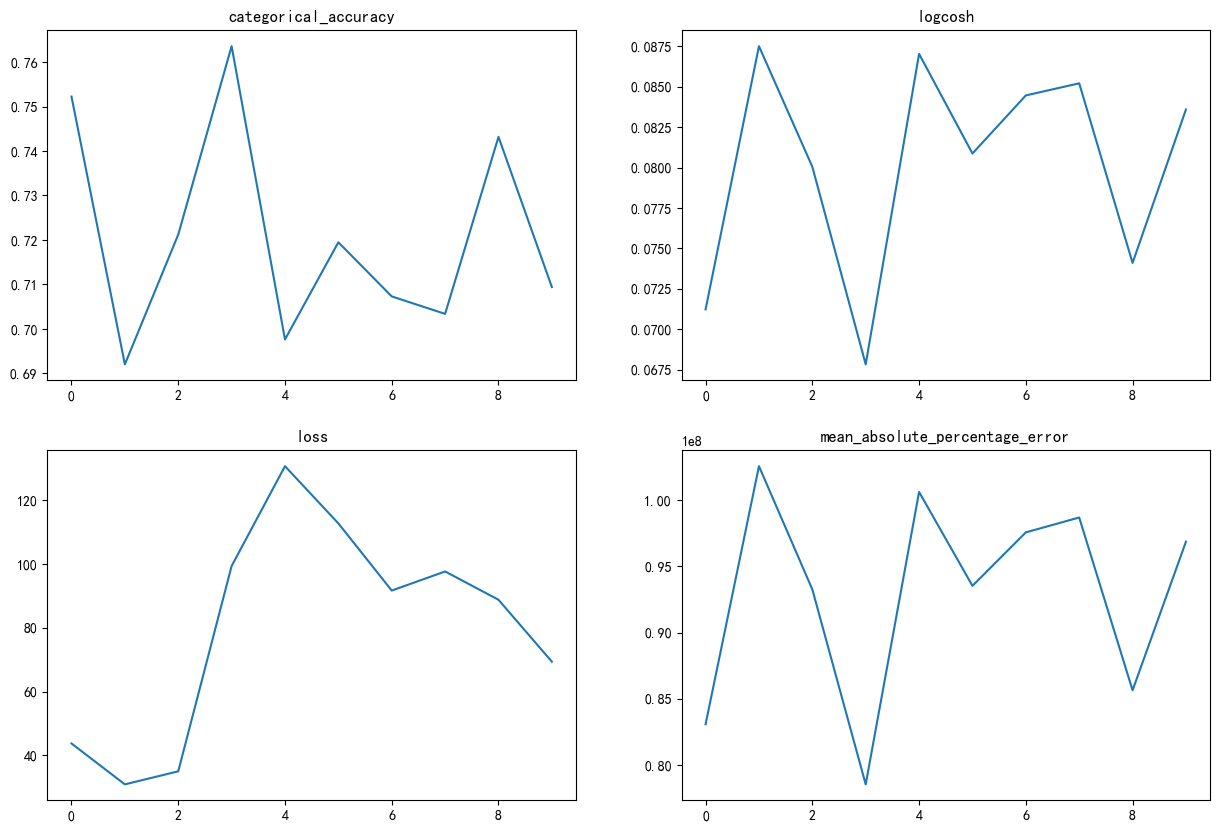

<Figure size 640x480 with 0 Axes>

In [33]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()
    plt.savefig(os.path.join(log_dir, 'learning_rate.png'))

plot_history_metrics(history) 



In [34]:
# 保存模型结构及配置参数
model_json = model.to_json()
with open(os.path.join(log_dir,'model_json.json'),'w') as json_file:
    json_file.write(model_json)


In [35]:

# # print(len(valWindow.repeat(1)))
# for train_x,y in test_feature.repeat(1).take(1):
#     print(train_x,y)

In [36]:
#对模型在测试集上进行评估
metrics = model.evaluate(test.repeat(1))
for name, value in zip(model.metrics_names, metrics):
    print(name, ': ', value)
# print("accuracy:", metrics[0], "accuracy:", metrics[1])


329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - categorical_accuracy: 0.9524 - logcosh: 0.0138 - loss: 3.6965 - mean_absolute_percentage_error: 15851420.0000
loss :  2.974015235900879
compile_metrics :  11252526.0


c:\AppData\.devhome\conda\envs\py311tf216\Lib\contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



In [37]:
pred_ds, test_steps_per_epoch, test_feature_col_names, test_label_col_names = proccess_data_dataset(df21, epochs, batch_size=batch_size)

# pred_ds = tf.data.Dataset.from_tensor_slices((proccess_data_df(df21)[feature_col_names]))

predictions = model.predict(pred_ds, verbose="auto")
# predictions?
predictions

--------------------------- = 
num_examples =  24964
batch_size =  50
steps_per_epoch =  498
colums =  17
(3,)
498/498 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step


c:\AppData\.devhome\conda\envs\py311tf216\Lib\contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



array([[1.0000000e+00, 2.1580764e-25, 6.2808727e-23],
       [1.0000000e+00, 2.1580764e-25, 6.2808727e-23],
       [1.0000000e+00, 2.1580764e-25, 6.2808727e-23],
       ...,
       [1.0000000e+00, 2.1580764e-25, 6.2808727e-23],
       [1.0000000e+00, 2.1580764e-25, 6.2808727e-23],
       [1.0000000e+00, 2.1580764e-25, 6.2808727e-23]], dtype=float32)

In [42]:
y_pred =predictions.argmax(axis=1)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [45]:
# 如果是多分类问题并且想比较类别概率分布
# 假设y_true和y_pred都是one-hot编码形式
# 可以选择几个样本画柱状图对比


y_true = test.map(lambda x, y: tf.argmax(y,axis=1))
for i, v in enumerate(y_true):
    if i > 3:
        break
    
    # print(v)
# print(predictions)

# for i in y_pred:
#     # print(i)
#     # print(i)
#     e=1
# num_samples_to_plot = len(y_pred)
# nrows = 2
# plt.figure(figsize=(30, 6))
# plt.subplot(nrows, 1, 1)
# plt.plot(y_true, label='Actual values', linewidth=1.0)
# plt.subplot(nrows, 1, 2)
# plt.plot(y_pred, label='Predicted values', linewidth=1.0)
# plt.legend(fontsize=14)
# plt.xlabel('Sample Index')
# ax = plt.gca()
# ax.set_xlim(left=0, right=num_samples_to_plot)
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values Comparison')
# plt.grid(True)
# plt.show()
y_true

tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)


<_MapDataset element_spec=TensorSpec(shape=(50,), dtype=tf.int64, name=None)>

In [40]:
# # data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# # ax = plt.gca()
# # ax.set_xlim(left=0, right=19000)


# # plt.show()
# times = df22[time_col_names].index.to_numpy()
# display(times)
# plt.plot(times, y, label="Actual", marker="o")
# plt.plot(times, predictions, label="Predicted", linestyle="--", marker="x")

# ax = plt.gca()
# ax.set_xlim(left=12000, right=18000)
# # 添加标题和标签
# plt.title("Actual vs. Predicted Values")
# plt.xlabel("Sample Index")
# plt.ylabel("Value")

# # 添加图例
# plt.legend()

# # 显示图形
# plt.show()

KeyError: 'val_loss'

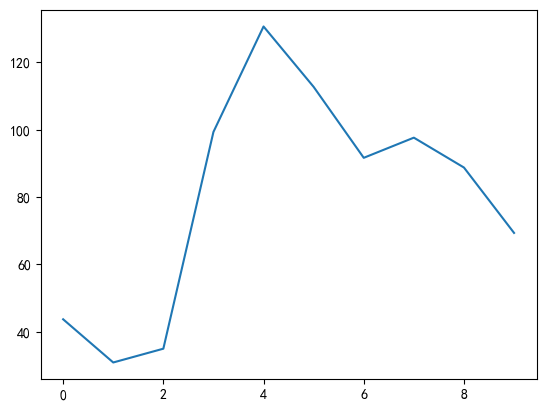

In [41]:
# display(history.history)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "epoch", "accuracy"], loc="upper right")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [ ]:
display(df22.columns)

In [ ]:
# data22, scaler22 = normalize(df22, numeric_col_names)
# X22 = data22[feature_col_names]
# y_test22 =normalizeY( df22[label_col_names])
# x_train22  = np.asarray(X22) .reshape(-1, feature_col_num)
# predY22 = model.predict(x_train22, batch_size=batch_size)


# data23, scaler23 = normalize(df23, numeric_col_names)
# X23 = data23[feature_col_names]
# y_test23 =normalizeY( df23[label_col_names])
# x_train23  = np.asarray(X23) .reshape(-1, feature_col_num)
# predY23 = model.predict(x_train23, batch_size=batch_size)






# display(predY22,predY23)

In [ ]:
# fig_acc = plt.figure(figsize=(9, 9))
# plt.plot(predY23[0:27000])
# plt.plot(y_test23[0:27000])
# plt.title("real vs pred")
# plt.ylabel("value")
# plt.xlabel("epoch")
# plt.xlim((19000, 23000))
# plt.legend(["pred", "real"], loc="upper left")
# plt.show()
